In [1]:
samples = []

with open('Data/oznaczenia.txt') as fp:
    for line in fp.readlines():
        [filename, end, start] = line[:-1].split("\t")
        samples.append((filename, int(start), int(end)))

samples

[('0001_1_.nii.gz', 105, 137),
 ('0001_2_.nii.gz', 100, 132),
 ('0002_1_.nii.gz', 93, 130),
 ('0002_2_.nii.gz', 87, 123),
 ('0003_1_.nii.gz', 100, 131),
 ('0003_2_.nii.gz', 101, 133),
 ('0004_1_.nii.gz', 169, 200),
 ('0004_2_.nii.gz', 162, 191),
 ('0005_1_.nii.gz', 120, 151),
 ('0006_1_.nii.gz', 183, 214),
 ('0006_2_.nii.gz', 179, 212),
 ('0007_1_.nii.gz', 189, 222),
 ('0007_2_.nii.gz', 108, 145),
 ('0008_1_.nii.gz', 186, 216),
 ('0008_2_.nii.gz', 169, 199),
 ('0009_1_.nii.gz', 183, 219),
 ('0009_2_.nii.gz', 173, 212),
 ('0010_1_.nii.gz', 168, 197),
 ('0010_2_.nii.gz', 104, 134)]

In [2]:
import torch
import nibabel as nib
import random

slices = []
targets = []

for filename, start, end in samples:
    img = nib.load(f"Data/{filename}").get_fdata()
    # Positive slices
    for depth in range(start, end + 1):
        s = img[:, :, depth]
        slices.append(torch.tensor(s, dtype=torch.float).unsqueeze(0))
        targets.append(1)
    negative_indices = list(range(0, start)) + list(range(end, img.shape[2]))
    chosen_negative_indices = random.sample(negative_indices, end - start + 1)
    for depth in chosen_negative_indices:
        s = img[:, :, depth]
        slices.append(torch.tensor(s, dtype=torch.float).unsqueeze(0))
        targets.append(0)
    

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(slices, targets, test_size=0.2)
print(len(X_train))
print(f"{sum(y_train)}/{len(y_train)}")
print(f"{sum(y_test)}/{len(y_test)}")
print(len(X_test))

1020
497/1020
141/256
256


In [84]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from typing import List
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

class SlicesDataset:
    def __init__(self, slices: torch.tensor, targets: List[bool], transform = None):
        self.slices = slices
        self.targets = torch.tensor(targets, dtype=torch.int64)
        self.transform = transform

    def __getitem__(self, idx):
        s = self.transform(self.slices[idx]) if self.transform is not None else self.slices[idx]
        target = F.one_hot(self.targets[idx], 2).float()
        return s, target
        
    def __len__(self):
        return len(self.targets)


transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Normalize(mean=[0.485], std=[0.229]),
])

train_dataset = SlicesDataset(X_train, y_train, transform)
test_dataset = SlicesDataset(X_test, y_test, transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

tensor([0., 1.])


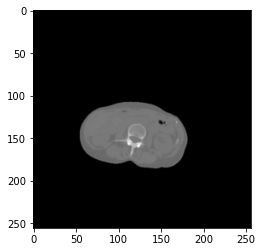

In [5]:
import matplotlib.pyplot as plt

s, target = next(iter(train_loader))

print(target[0])
plt.gray()
plt.imshow(s[0][0])

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torchvision.models import densenet121
from torch import nn


model = densenet121(num_classes=2)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = model.to(device)
model

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        """
        Initialize a Convolutional Neural Network with Batch Normalization.
        
        Args:
            num_classes (int): Number of output classes (default: 10 for CIFAR-10)
        """
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers with batch normalization
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        # self.conv2 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, bias=False),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(inplace=True)
        # )
        
        # self.conv3 = nn.Sequential(
        #     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, bias=False),
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(inplace=True)
        # )
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(8192, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.20)
        )
        
        self.fc2 = nn.Linear(256, num_classes)

    
    def forward(self, x):
        # First convolutional block
        x = self.pool(self.conv1(x))
        
        # Second convolutional block
        # x = self.pool(self.conv2(x))
        
        # # Third convolutional block
        # x = self.pool(self.conv3(x))
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers with batch norm and dropout
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

model = SimpleCNN(2).to(device)
model

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Sequential(
    (0): Linear(in_features=8192, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [67]:
from tqdm import tqdm

def train(model, train_loader, optimizer, criterion, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc="Training Epoch"):
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        _, true_predictions = torch.max(labels, 1)
        correct += (predicted == true_predictions).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total * 100
    return epoch_loss, epoch_accuracy

# Testing loop
def test(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # No gradient computation during testing
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track the loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            _, true_predictions = torch.max(labels, 1)
            correct += (predicted == true_predictions).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(test_loader)
    epoch_accuracy = correct / total * 100
    return epoch_loss, epoch_accuracy


def train_loop(model, train_loader, test_loader, criterion, optimizer, device, num_epochs):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    for epoch in range(num_epochs):
        # Training
        train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    
        # Testing
        test_loss, test_accuracy = test(model, test_loader, criterion, device)
        print(f"Epoch {epoch+1}/{num_epochs} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
    return {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_acc": train_accuracies,
        "test_acc": test_accuracies
    }

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

history = train_loop(model, train_loader, test_loader, criterion, optimizer, device, 50)

Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.45it/s]


Epoch 1/50 - Train Loss: 2.4185, Train Accuracy: 50.88%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


Epoch 1/50 - Test Loss: 0.9112, Test Accuracy: 44.92%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.73it/s]


Epoch 2/50 - Train Loss: 0.7631, Train Accuracy: 60.78%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


Epoch 2/50 - Test Loss: 0.6476, Test Accuracy: 60.94%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.44it/s]


Epoch 3/50 - Train Loss: 0.6310, Train Accuracy: 61.18%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.67it/s]


Epoch 3/50 - Test Loss: 0.6472, Test Accuracy: 51.95%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.46it/s]


Epoch 4/50 - Train Loss: 0.5132, Train Accuracy: 73.33%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.86it/s]


Epoch 4/50 - Test Loss: 0.4517, Test Accuracy: 83.59%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.71it/s]


Epoch 5/50 - Train Loss: 0.4612, Train Accuracy: 78.73%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.96it/s]


Epoch 5/50 - Test Loss: 0.4332, Test Accuracy: 82.03%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.68it/s]


Epoch 6/50 - Train Loss: 0.4142, Train Accuracy: 83.92%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.70it/s]


Epoch 6/50 - Test Loss: 0.3739, Test Accuracy: 87.11%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.41it/s]


Epoch 7/50 - Train Loss: 0.3735, Train Accuracy: 84.90%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.79it/s]


Epoch 7/50 - Test Loss: 0.3406, Test Accuracy: 88.28%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.69it/s]


Epoch 8/50 - Train Loss: 0.3488, Train Accuracy: 86.96%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.80it/s]


Epoch 8/50 - Test Loss: 0.3410, Test Accuracy: 89.06%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.45it/s]


Epoch 9/50 - Train Loss: 0.3217, Train Accuracy: 87.84%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.70it/s]


Epoch 9/50 - Test Loss: 0.2945, Test Accuracy: 91.41%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.45it/s]


Epoch 10/50 - Train Loss: 0.2924, Train Accuracy: 89.22%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.58it/s]


Epoch 10/50 - Test Loss: 0.2664, Test Accuracy: 90.62%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.58it/s]


Epoch 11/50 - Train Loss: 0.2786, Train Accuracy: 89.80%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.48it/s]


Epoch 11/50 - Test Loss: 0.2532, Test Accuracy: 91.80%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.15it/s]


Epoch 12/50 - Train Loss: 0.2521, Train Accuracy: 91.27%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


Epoch 12/50 - Test Loss: 0.2360, Test Accuracy: 92.58%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.20it/s]


Epoch 13/50 - Train Loss: 0.2506, Train Accuracy: 90.98%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


Epoch 13/50 - Test Loss: 0.2255, Test Accuracy: 92.19%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.12it/s]


Epoch 14/50 - Train Loss: 0.2297, Train Accuracy: 91.86%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.53it/s]


Epoch 14/50 - Test Loss: 0.2102, Test Accuracy: 92.97%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.35it/s]


Epoch 15/50 - Train Loss: 0.2179, Train Accuracy: 92.84%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


Epoch 15/50 - Test Loss: 0.1900, Test Accuracy: 94.14%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.64it/s]


Epoch 16/50 - Train Loss: 0.1910, Train Accuracy: 93.63%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.58it/s]


Epoch 16/50 - Test Loss: 0.1764, Test Accuracy: 94.14%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.43it/s]


Epoch 17/50 - Train Loss: 0.1954, Train Accuracy: 92.55%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.58it/s]


Epoch 17/50 - Test Loss: 0.1781, Test Accuracy: 94.53%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.53it/s]


Epoch 18/50 - Train Loss: 0.1747, Train Accuracy: 95.10%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


Epoch 18/50 - Test Loss: 0.1887, Test Accuracy: 92.97%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.69it/s]


Epoch 19/50 - Train Loss: 0.1869, Train Accuracy: 94.51%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.17it/s]


Epoch 19/50 - Test Loss: 0.1555, Test Accuracy: 94.92%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.68it/s]


Epoch 20/50 - Train Loss: 0.1699, Train Accuracy: 94.31%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.45it/s]


Epoch 20/50 - Test Loss: 0.1530, Test Accuracy: 95.31%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.32it/s]


Epoch 21/50 - Train Loss: 0.1646, Train Accuracy: 94.12%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.59it/s]


Epoch 21/50 - Test Loss: 0.1562, Test Accuracy: 94.53%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.35it/s]


Epoch 22/50 - Train Loss: 0.1678, Train Accuracy: 94.51%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.73it/s]


Epoch 22/50 - Test Loss: 0.1534, Test Accuracy: 94.53%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.54it/s]


Epoch 23/50 - Train Loss: 0.1638, Train Accuracy: 94.22%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.71it/s]


Epoch 23/50 - Test Loss: 0.1438, Test Accuracy: 94.92%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.46it/s]


Epoch 24/50 - Train Loss: 0.1462, Train Accuracy: 94.90%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.39it/s]


Epoch 24/50 - Test Loss: 0.1305, Test Accuracy: 95.70%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.40it/s]


Epoch 25/50 - Train Loss: 0.1333, Train Accuracy: 95.49%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


Epoch 25/50 - Test Loss: 0.1127, Test Accuracy: 97.66%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.42it/s]


Epoch 26/50 - Train Loss: 0.1094, Train Accuracy: 96.96%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.62it/s]


Epoch 26/50 - Test Loss: 0.1066, Test Accuracy: 97.66%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.54it/s]


Epoch 27/50 - Train Loss: 0.1059, Train Accuracy: 96.86%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.74it/s]


Epoch 27/50 - Test Loss: 0.1023, Test Accuracy: 98.05%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.55it/s]


Epoch 28/50 - Train Loss: 0.1098, Train Accuracy: 96.08%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.74it/s]


Epoch 28/50 - Test Loss: 0.1024, Test Accuracy: 98.05%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.53it/s]


Epoch 29/50 - Train Loss: 0.1180, Train Accuracy: 96.18%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.61it/s]


Epoch 29/50 - Test Loss: 0.1065, Test Accuracy: 98.05%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.62it/s]


Epoch 30/50 - Train Loss: 0.1029, Train Accuracy: 96.27%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


Epoch 30/50 - Test Loss: 0.0893, Test Accuracy: 98.05%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.48it/s]


Epoch 31/50 - Train Loss: 0.1021, Train Accuracy: 96.57%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.76it/s]


Epoch 31/50 - Test Loss: 0.0933, Test Accuracy: 97.66%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.55it/s]


Epoch 32/50 - Train Loss: 0.0910, Train Accuracy: 96.86%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


Epoch 32/50 - Test Loss: 0.0905, Test Accuracy: 98.05%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.54it/s]


Epoch 33/50 - Train Loss: 0.0820, Train Accuracy: 97.45%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.70it/s]


Epoch 33/50 - Test Loss: 0.0892, Test Accuracy: 97.66%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.54it/s]


Epoch 34/50 - Train Loss: 0.0766, Train Accuracy: 98.24%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.80it/s]


Epoch 34/50 - Test Loss: 0.0849, Test Accuracy: 97.66%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.63it/s]


Epoch 35/50 - Train Loss: 0.0766, Train Accuracy: 98.14%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.80it/s]


Epoch 35/50 - Test Loss: 0.0847, Test Accuracy: 97.66%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.42it/s]


Epoch 36/50 - Train Loss: 0.0729, Train Accuracy: 97.94%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.73it/s]


Epoch 36/50 - Test Loss: 0.0787, Test Accuracy: 97.66%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.37it/s]


Epoch 37/50 - Train Loss: 0.0869, Train Accuracy: 97.84%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.48it/s]


Epoch 37/50 - Test Loss: 0.0899, Test Accuracy: 97.27%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.43it/s]


Epoch 38/50 - Train Loss: 0.0770, Train Accuracy: 97.35%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.56it/s]


Epoch 38/50 - Test Loss: 0.0923, Test Accuracy: 97.27%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.34it/s]


Epoch 39/50 - Train Loss: 0.0834, Train Accuracy: 97.16%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.54it/s]


Epoch 39/50 - Test Loss: 0.0872, Test Accuracy: 97.27%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.53it/s]


Epoch 40/50 - Train Loss: 0.0727, Train Accuracy: 97.84%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.76it/s]


Epoch 40/50 - Test Loss: 0.0775, Test Accuracy: 97.66%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.54it/s]


Epoch 41/50 - Train Loss: 0.0787, Train Accuracy: 97.25%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.77it/s]


Epoch 41/50 - Test Loss: 0.0763, Test Accuracy: 97.66%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.36it/s]


Epoch 42/50 - Train Loss: 0.0630, Train Accuracy: 98.24%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.65it/s]


Epoch 42/50 - Test Loss: 0.0724, Test Accuracy: 97.66%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.50it/s]


Epoch 43/50 - Train Loss: 0.0610, Train Accuracy: 98.24%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.91it/s]


Epoch 43/50 - Test Loss: 0.0676, Test Accuracy: 98.44%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.71it/s]


Epoch 44/50 - Train Loss: 0.0640, Train Accuracy: 98.24%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


Epoch 44/50 - Test Loss: 0.0714, Test Accuracy: 98.83%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.35it/s]


Epoch 45/50 - Train Loss: 0.0594, Train Accuracy: 98.33%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.11it/s]


Epoch 45/50 - Test Loss: 0.0612, Test Accuracy: 98.44%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.83it/s]


Epoch 46/50 - Train Loss: 0.0534, Train Accuracy: 98.33%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


Epoch 46/50 - Test Loss: 0.0677, Test Accuracy: 97.66%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.83it/s]


Epoch 47/50 - Train Loss: 0.0504, Train Accuracy: 98.73%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.10it/s]


Epoch 47/50 - Test Loss: 0.0655, Test Accuracy: 98.05%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.79it/s]


Epoch 48/50 - Train Loss: 0.0467, Train Accuracy: 98.53%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.21it/s]


Epoch 48/50 - Test Loss: 0.0609, Test Accuracy: 98.44%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.88it/s]


Epoch 49/50 - Train Loss: 0.0539, Train Accuracy: 98.43%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.11it/s]


Epoch 49/50 - Test Loss: 0.0588, Test Accuracy: 98.44%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.88it/s]


Epoch 50/50 - Train Loss: 0.0491, Train Accuracy: 98.33%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.14it/s]

Epoch 50/50 - Test Loss: 0.0679, Test Accuracy: 97.66%


In [68]:
history["test_acc"][-10:]

[97.65625,
 97.65625,
 98.4375,
 98.828125,
 98.4375,
 97.65625,
 98.046875,
 98.4375,
 98.4375,
 97.65625]

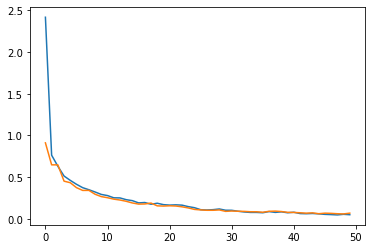

In [71]:
import matplotlib.pyplot as plt

epochs = list(range(len(history["test_acc"])))
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.plot(epochs, history["test_loss"], label="Test loss")

In [172]:
import random

ct = nib.load(f"Data/0004_1_.nii.gz").get_fdata()

slices = []
labels = []
for depth in range(ct.shape[2]):
    slices.append(torch.tensor(ct[:, :, depth], dtype=torch.float).unsqueeze(0))
    label = 1 if depth >= start and depth <= end else 0
    labels.append(label)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Normalize(mean=[0.485], std=[0.229]),
])

validation_dataset = SlicesDataset(slices, labels, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

test(model, validation_loader, criterion, device)

Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.94it/s]


(3.2866510662399833, 70.09646302250803)

In [173]:
def make_classification(model, ct, device):
    result = []
    for depth in range(ct.shape[2]):
        s = transform(torch.tensor(ct[:, :, depth], dtype=torch.float, device=device).unsqueeze(0))
        c = torch.argmax(model(s.unsqueeze(0))).item()
        result.append(c)
    return result

classification = make_classification(model, ct, device)

In [ ]:
classification

In [196]:
def find_voi(classification, n_neigh=3):
    result = []
    for i in range(len(classification)):
        left = classification[max(0, i - n_neigh):i + 1]
        right = classification[i:min(len(classification), i + n_neigh)]
        decision = int((all(left) and len(left) != 1) or (all(right) and len(right) != 1))
        result.append(decision)
    start = result.index(1)
    end = start + sum(result)
    return start, end

print(start, end)
find_voi(classification, n_neigh=10)

100 132


(87, 143)

In [206]:
import pandas as pd

n_neigh = 10

data = {
    "sample": list(),
    "start": list(),
    "end": list(),
    "predicted_start": list(),
    "predicted_end": list(),
    "metric": list()
}

for sample, start, end in samples:
    ct = nib.load(f"Data/{sample}").get_fdata()
    classification = make_classification(model, ct, device)
    predicted_start, predicted_end = find_voi(classification, n_neigh)
    metric = abs(predicted_start - start) + abs(predicted_end - end)
    data["sample"].append(sample)
    data["start"].append(start)
    data["end"].append(end)
    data["predicted_start"].append(predicted_start)
    data["predicted_end"].append(predicted_end)
    data["metric"].append(metric)

df = pd.DataFrame(data)

In [207]:
df["metric"].mean()

9.947368421052632